# Spot-to-spot alignment of DLPFC data (Partial alignment)

In this tutorial, we showcase **GALA’s robustness under partial alignment**, where a **cropped region of slice 3** is aligned to slice 2 in Sample C of the DLPFC dataset.  
This scenario highlights GALA’s ability to handle incomplete spatial correspondence between source and target slices.

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scanpy as sc
import seaborn as sns
import os
import time
import pickle

import warnings
warnings.filterwarnings("ignore")

# data loading path
data_path = os.path.expanduser('../Data/DLPFC')  # Update this path to your data directory  
results_path = os.path.expanduser('./Results/tutorials')  # Directory to save results

# Load Data and Crop Source Slice

We first load the pre-processed DLPFC data and then **crop slice 3** to simulate partial coverage.  
(Refer to Tutorial 1 to retrieve the corresponding slices.)  

This setup allows us to evaluate GALA’s performance in aligning **partially overlapping slices**.

In [7]:
sample_list = ["151507", "151508", "151509","151510", "151669", "151670","151671", "151672", "151673","151674", "151675", "151676"]
adatas = {
    sample: sc.read_h5ad(os.path.join(data_path, f"{sample}_preprocessed.h5"))
    for sample in sample_list
}
sample_groups = [["151507", "151508", "151509","151510"], [ "151669", "151670","151671", "151672"], [ "151673","151674", "151675", "151676"]]
layer_to_color_map = {'Layer{0}'.format(i+1):sns.color_palette()[i] for i in range(6)}
layer_to_color_map['WM'] = sns.color_palette()[6]

###
### Choose Sample and slices.
### In this tutorial, we choose sample 151674 (slice 2 of Sample C) as target and 151675 (slice 3 of Sample C)  as source.
sample_choose = 2
target = adatas[sample_groups[sample_choose][1]]
raw_source = adatas[sample_groups[sample_choose][2]]

Crop slice 3 of Sample C to serve as the **source**.  

In this experiment, we retain **60% of the slice** ($s = 0.6$) from the **left region** along the $x$-axis (`is_lower = True`), simulating partial overlap with the target slice.

In [8]:
from GALA.utils import partial_cut

s = 0.6
# crop
source = partial_cut(raw_source, s, axis = 'x', is_lower = True)
# common genes
shared_gene_names = target.var_names.intersection(source.var_names)
target = target[:,shared_gene_names]
source = source[:,shared_gene_names]

## Plot the Raw Slices

For visualization purposes, we **do not crop the H&E image** of slice 3 here.  
In the subsequent analysis, the **cropped histological image** will be incorporated as a modality in GALA.

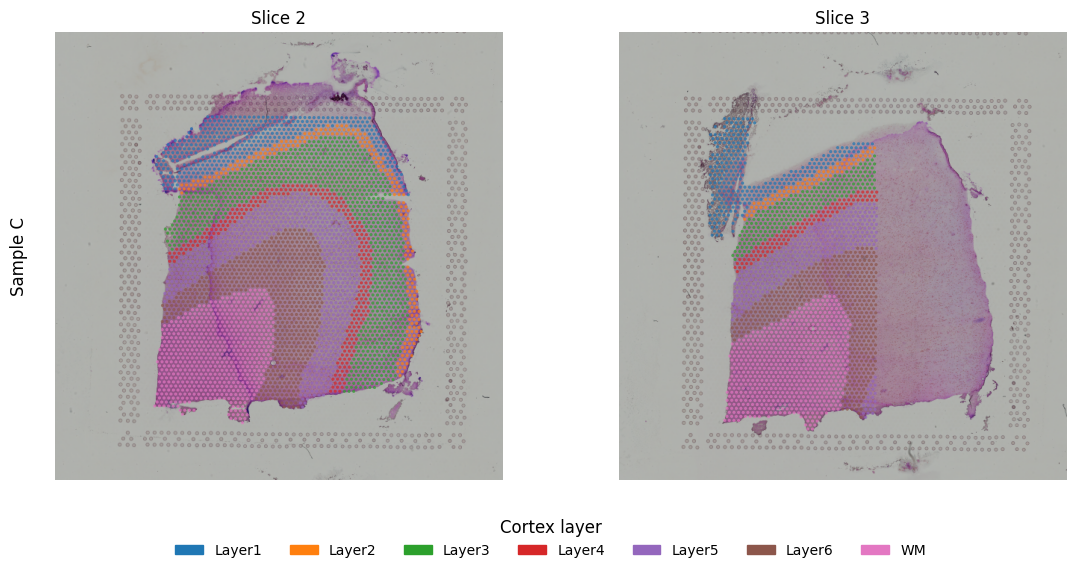

In [4]:
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs[0].text(-0.1, 0.5, 'Sample C', fontsize=12, rotation='vertical',
            transform=axs[0].transAxes, verticalalignment='center')
for i in range(2):
    if i ==0:
        adata = target
    else :
        adata = source
    img = adata.uns['lowres_image']
    colors = list(adata.obs['Ground Truth'].astype('str').map(layer_to_color_map))
    axs[i].imshow(img)
    axs[i].scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1],
                   linewidth=0, s=20, marker=".", color=colors,alpha = 0.7)
    axs[i].set_title(f'Slice {i+2}', size=12)
    axs[i].axis('off')
# Construct legend handles
categories = adata.obs['Ground Truth'].cat.categories
handles = [mpatches.Patch(color=layer_to_color_map[c], label=c) for c in categories]
fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5,-0.15),
           ncol=len(categories), fontsize=10, title='Cortex layer', title_fontsize=12,frameon=False)

plt.tight_layout()
plt.show()


## Rasterisation

We follow the same rasterization procedure as in Tutorial 1.  
Briefly, we convert the spatial transcriptomics data of both the source (cropped slice 3) and target (slice 2) into rasterized grids.  
This prepares the data for GALA’s multimodal alignment.

In [5]:
from GALA.utils import top_p_genes
from GALA.utils import rasterize_channel, rasterize_image

###
### select top p genes
###
p = 3 # Number of predictive genes choosen
top_gene_names = top_p_genes(source, shared_gene_names, p = p)
print(top_gene_names)

### Hyper-parameters
alp = 0.5  # Fusion weights of molecular and morphological modalities
scale = target.uns['scale']['tissue_lowres_scalef']
dx = scale*20 # approximate to 1
### Expression
# source 
X = np.array(source[:,top_gene_names].X.todense())
xi = source.obsm['spatial'][:,0]
yi = source.obsm['spatial'][:,1]
gi = np.array(source.X.sum(axis=1))
si = np.concatenate([X, gi], axis=1)
XI,YI,I_expr = rasterize_channel(xi, yi, si,dx = dx)
# target
X = np.array(target[:,top_gene_names].X.todense())
xj = target.obsm['spatial'][:,0]
yj = target.obsm['spatial'][:,1]
gj = np.array(target.X.sum(axis = 1))
sj = np.concatenate([X, gj], axis=1)
XJ,YJ,J_expr = rasterize_channel(xj, yj, sj,dx = dx)

### Image
if alp ==1.0:
    I = I_expr
    J = J_expr
else :
    # Source
    imgi = source.uns['lowres_image']
    _,_,I_img = rasterize_image(xi, yi, imgi,dx = dx)
    I_img = I_img[None,...]
    I = np.concatenate([alp*I_expr,(1-alp)*I_img],axis = 0)
    
    # Target
    imgj = target.uns['lowres_image']
    _,_,J_img = rasterize_image(xj, yj, imgj, dx = dx)
    J_img = J_img[None,...]
    J = np.concatenate([alp*J_expr,(1-alp)*J_img],axis = 0)
    

Index(['MBP', 'GFAP', 'MT-CO1'], dtype='object')
0 of 2140
2139 of 2140
0 of 3635
3634 of 3635
0 of 2140
2139 of 2140
0 of 3635
3634 of 3635


Visualize rasterized expression and histology images

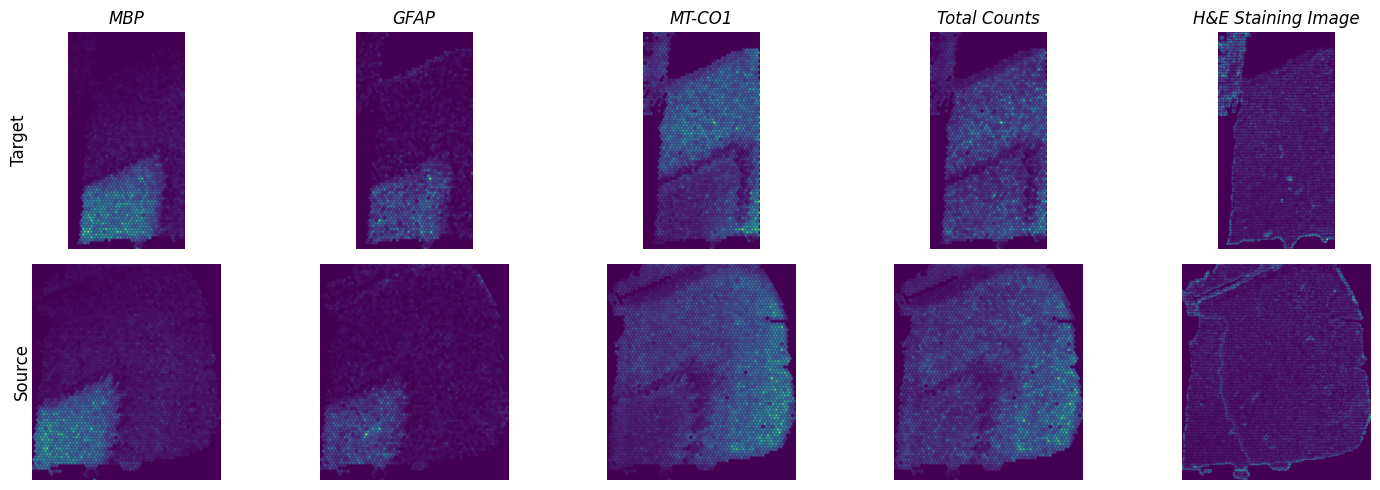

In [6]:
# Column names for the 5 channels: top genes, total counts, H&E image
colnames = ['MBP', 'GFAP', 'MT-CO1', 'Total Counts', 'H&E Staining Image']
fig, axs = plt.subplots(2, 5,figsize=(15, 5))
axs[0, 0].text(-0.5, 0.5, 'Target', fontsize=12, rotation='vertical',
               transform=axs[0, 0].transAxes, verticalalignment='center')
axs[1, 0].text(-0.1, 0.5, 'Source', fontsize=12, rotation='vertical',
               transform=axs[1, 0].transAxes, verticalalignment='center')
# Display each channel in a column
for i in range(5):
    axs[0, i].imshow(I[i])
    axs[0, i].set_title(colnames[i], fontsize=12,fontstyle='italic')
    axs[1, i].imshow(J[i])
    axs[0, i].axis('off')
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

# GALA

In [7]:
from GALA.utils import alignedada,to_cpu
from GALA.gala import gala

### Input data
xI = [YI,XI]
xJ = [YJ,XJ]
# Prior seeting for easier global search in GA. It is optional. However, observing the raw slices, the prior knowledge will enforce the robust performance of GA by reducing the number of parameters.
gene_space=[
        {'low': -45, 'high': 45},   # angle
        {'low': 1.0, 'high': 1.0},  # sy
        {'low': 1.0, 'high': 1.0},  # sx
        {},  # ty
        {}   # tx
    ]

### Parameters in the whole framework
params = {'num_generations' : 1000,
          'num_iterations': 5000,
          'num_repeats': 2,
          'epV': dx,
          'a': dx,
          'sigmaR':1000,
          'sigmaM': I.std(),
          'sigmaB': J.std(),
          'random_seed': 42
          }
start = time.time()
resu = gala(xI,I,xJ,J,gene_space = gene_space, **params)
print('Alignment Runtime: ' + str(time.time() - start)) 
### copy results from GPU to CPU 
if torch.cuda.is_available():
    resu = to_cpu(resu)

# with open(os.path.join(results_path, "resu_left_partial_slice3_to_2_SampleC.pkl"), 'wb') as f:
#     pickle.dump(resu, f)

Iteration 1 of 2
Generation = 200
Fitness    = 0.00040650221400706185
Change     = 0.00040650221400706185
Generation = 400
Fitness    = 0.00042001396063252313
Change     = 1.3511746625461285e-05
Generation = 600
Fitness    = 0.00042207597023485925
Change     = 2.0620096023361194e-06
Generation = 800
Fitness    = 0.00042424036810854044
Change     = 2.1643978736811875e-06
Generation = 1000
Fitness    = 0.00042448156812950665
Change     = 2.412000209662071e-07
Best transformation: angle=0.03, sx=1.00, sy=1.00, tx=-77.11, ty=-18.72
0 of 5000
500 of 5000
1000 of 5000
1500 of 5000
2000 of 5000
2500 of 5000
3000 of 5000
3500 of 5000
4000 of 5000
4500 of 5000
4999 of 5000
Iteration 2 of 2
Generation = 200
Fitness    = 0.00040650221400706185
Change     = -1.79793541224448e-05
Generation = 400
Fitness    = 0.00042001396063252313
Change     = 1.3511746625461285e-05
Generation = 600
Fitness    = 0.00042207597023485925
Change     = 2.0620096023361194e-06
Generation = 800
Fitness    = 0.000424240368

# Results Analysis

We first load the saved results from the GALA alignment of the partially cropped slice 3 to slice 2.  
Next, we visualise the convergence of the **objective function** during the optimisation, which reflects the progressive improvement of alignment.

Enery value before alignment: 204643.81004761226; Enery value after alignment: 62034.738479741754


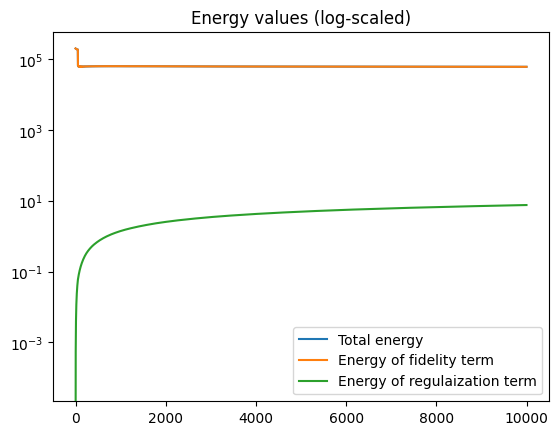

In [10]:
with open(os.path.join(results_path, "resu_left_partial_slice3_to_2_SampleC.pkl"), 'rb') as f:
   resu = pickle.load(f)

### Convergence of objective function 
E = resu['E']
print(f'Enery value before alignment: {E[0][0]}; Enery value after alignment: {E[-1][0]}')

fig, ax = plt.subplots()
ax.plot(E)
ax.legend(['Total energy','Energy of fidelity term','Energy of regulaization term'])
ax.set_yscale('log')
ax.set_title('Energy values (log-scaled)')
plt.show()

## Visualization of alignment components 
We first print the mean of matching probabilities $P_M$ and plot matching probability matrix.

Matching probabilities: tensor([0.6535, 0.3465])


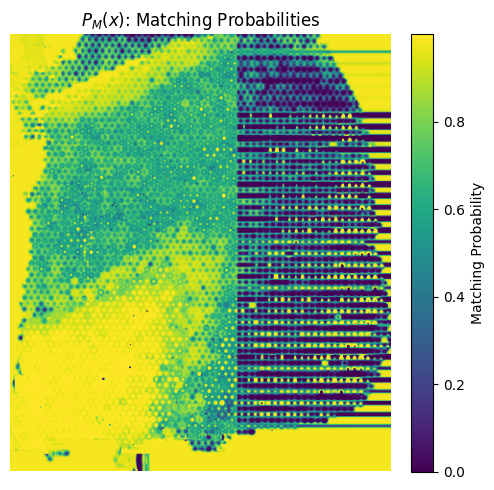

In [11]:
### Matching and Background Probabilities
PM = resu['WM'].cpu()
PB = resu['WB'].cpu()

P = torch.stack((PM,PB))
pi = torch.sum(P,dim=(1,2))
pi += torch.max(pi)*1e-6
pi /= torch.sum(pi)
print('Matching probabilities:', pi)

fig,ax = plt.subplots(figsize = (6,5))
im = ax.imshow(PM)
ax.set_title(r'$P_M(x)$: Matching Probabilities')
ax.axis('off')
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Matching Probability')  

plt.tight_layout()
plt.show()

Then we compute diffeomorphic mapping $\phi^v(A(x))$ and its inverse $(\phi^v(A(x)))^{-1}$.

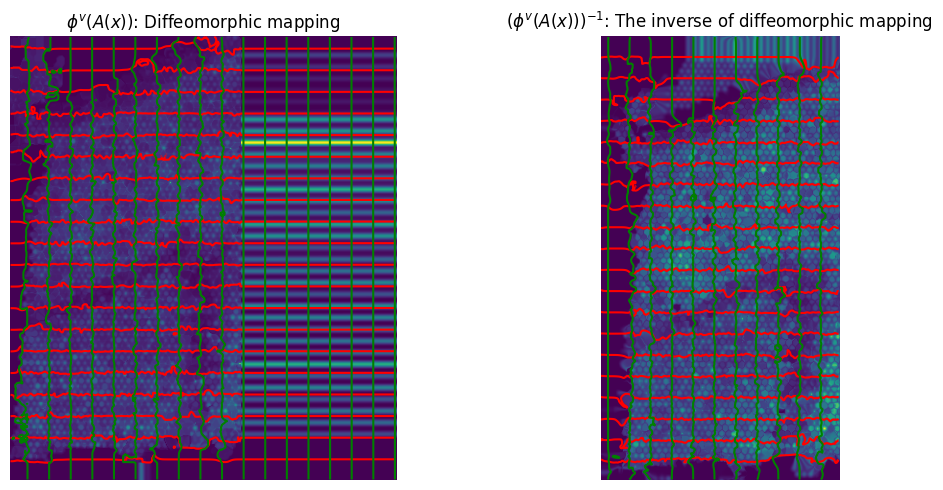

In [10]:
from GALA.utils import build_transform, transform_image_source_to_target,transform_image_target_to_source
### Phi mapping: source to target
xv = resu['xv']
v = resu['v']
A = resu['A']

xI = [YI,XI]
xJ = [YJ,XJ]
xI = [torch.as_tensor(x,device = 'cpu') for x in xI]
xJ = [torch.as_tensor(x,device = 'cpu') for x in xJ]
def extent_from_x(xJ):
    dJ = [x[1]-x[0] for x in xJ]
    extentJ = ( (xJ[1][0] - dJ[1]/2.0).item(),
               (xJ[1][-1] + dJ[1]/2.0).item(),
               (xJ[0][-1] + dJ[0]/2.0).item(),
               (xJ[0][0] - dJ[0]/2.0).item())
    return extentJ
### Forward mapping: build the diffeomorphic transform
phii = build_transform(xv,v,A,torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1))
aI = I[3]
aI = aI[None,...]
phiI = transform_image_source_to_target(xv,v,A,xI,aI,torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1))
extentJ = extent_from_x((YJ,XJ))
### Backward mapping: build the diffeomorphic transform
phij = build_transform(xv,v,A,torch.stack(torch.meshgrid(*xI,indexing='ij'),-1),forward  = True)  
aJ = J[3]
aJ = aJ[None,...]
phiJ = transform_image_target_to_source(xv,v,A,xJ,aJ,torch.stack(torch.meshgrid(*xI,indexing='ij'),-1))
extentI = extent_from_x((YI,XI))



### Visualizing matching probabilities and diffeomorphic mapping
fig,ax = plt.subplots(1,2,figsize=(12, 5))
# Right: Diffeomorphic mapping overlay
ax[0].contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels= np.arange( phii.min(), phii.max(), 20)  )
ax[0].contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels= np.arange( phii.min(), phii.max(), 20))
ax[0].imshow(phiI.permute(1,2,0)/torch.max(phiI),extent = extentJ)
ax[0].set_title(r'$\phi^v(A(x))$: Diffeomorphic mapping')
ax[0].axis('off')

# Inverse diffeomorphic mapping: target -> source
ax[1].contour(XI,YI,phij[...,0],colors='r',linestyles='-',levels = np.arange(phij.min(), phij.max(), 20) )
ax[1].contour(XI,YI,phij[...,1],colors='g',linestyles='-',levels = np.arange(phij.min(), phij.max(), 20))
ax[1].imshow(phiJ.permute(1,2,0)/torch.max(phiJ),extent = extentI)
ax[1].set_title(r'$(\phi^v(A(x)))^{-1}$: The inverse of diffeomorphic mapping')
ax[1].axis('off')


plt.tight_layout()
plt.show()


## Aligned Slices

We next visualise the results of GALA’s alignment.  
The plots compare the **source (cropped slice 3)** and **target (slice 2)** both **before and after alignment**, highlighting how GALA recovers spatial correspondence even under partial overlap.

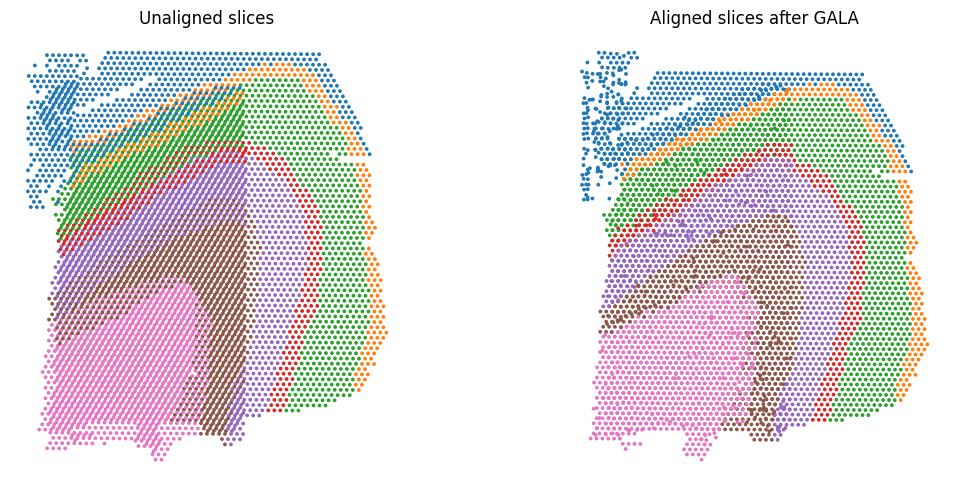

In [11]:
from GALA.utils import alignedada

fs = 30

# aligned slice
aligned_source = alignedada(resu, source)
aligned_source.obsm = {'spatial': aligned_source.obsm['aligned'].copy()}

fig, ax = plt.subplots(1,2, figsize=(12,5))
colors_t = list(target.obs['Ground Truth'].astype('str').map(layer_to_color_map))
colors_s = list(aligned_source.obs['Ground Truth'].astype('str').map(layer_to_color_map))
### Unaligned slices    
ax[0].scatter(target.obsm['spatial'][:, 0], target.obsm['spatial'][:, 1],linewidth=0, s=fs, marker=".", color=colors_t)
ax[0].scatter(source.obsm['spatial'][:, 0], source.obsm['spatial'][:, 1],linewidth=0, s=fs, marker=".", color=colors_s)
ax[0].set_title('Unaligned slices', size=12)
ax[0].axis('off')
ax[0].invert_yaxis()
ax[0].set_aspect('equal')

ax[1].scatter(target.obsm['spatial'][:, 0], target.obsm['spatial'][:, 1],linewidth=0, s=fs, marker=".", color=colors_t)

ax[1].scatter(aligned_source.obsm['spatial'][:, 0], aligned_source.obsm['spatial'][:, 1],linewidth=0, s=fs, marker=".", color=colors_s)
ax[1].set_title('Aligned slices after GALA', size=12)
ax[1].axis('off')
ax[1].invert_yaxis()
ax[1].set_aspect('equal')

plt.tight_layout()
plt.show()



# Partial Alignment Example: Bottom Retained

In this alternative scenario, we crop **slice 3** of Sample C to retain the **bottom 60%** of the tissue ($s = 0.6$, along the $y$-axis, `is_lower = False`).  
All subsequent steps, including rasterization, prior setting, and GALA alignment, follow the same procedure as in the **left-region retained** example.  

This setup allows us to assess GALA’s robustness when the **remaining tissue region is at the bottom** rather than the left.

## Crop Slice 3 and Plot

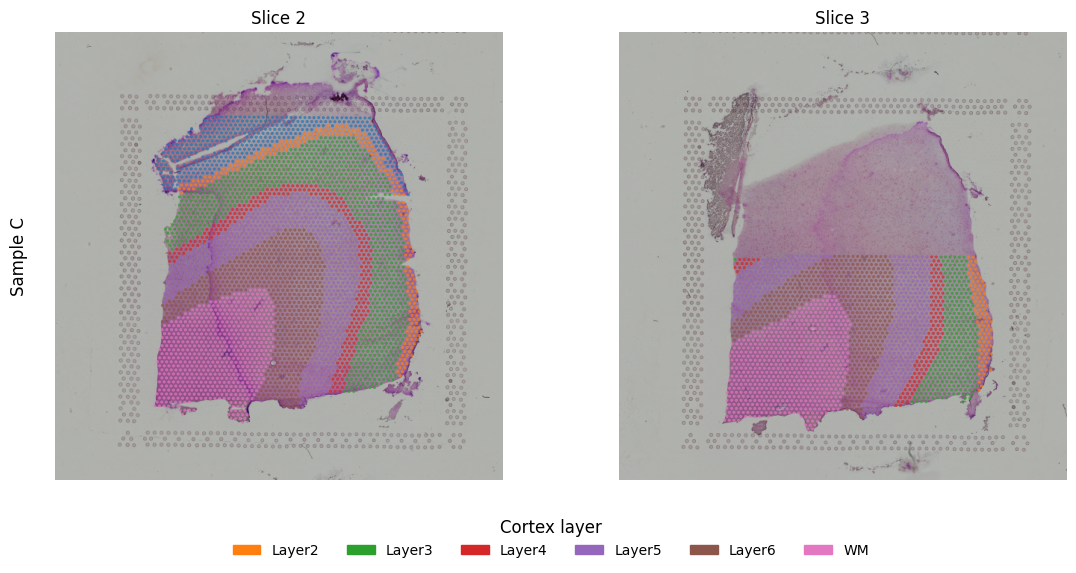

In [12]:
s = 0.6
###
### crop slice3
###
source = partial_cut(raw_source, s, axis = 'y', is_lower = False)
# common genes
shared_gene_names = target.var_names.intersection(source.var_names)
target = target[:,shared_gene_names]
source = source[:,shared_gene_names]

fig, axs = plt.subplots(1,2, figsize = (12,5))
axs[0].text(-0.1, 0.5, 'Sample C', fontsize=12, rotation='vertical',
            transform=axs[0].transAxes, verticalalignment='center')
for i in range(2):
    if i ==0:
        adata = target
    else :
        adata = source
    img = adata.uns['lowres_image']
    colors = list(adata.obs['Ground Truth'].astype('str').map(layer_to_color_map))
    axs[i].imshow(img)
    axs[i].scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1],
                   linewidth=0, s=20, marker=".", color=colors,alpha = 0.7)
    axs[i].set_title(f'Slice {i+2}', size=12)
    axs[i].axis('off')
# Construct legend handles
categories = adata.obs['Ground Truth'].cat.categories
handles = [mpatches.Patch(color=layer_to_color_map[c], label=c) for c in categories]
fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5,-0.15),
           ncol=len(categories), fontsize=10, title='Cortex layer', title_fontsize=12,frameon=False)

plt.tight_layout()
plt.show()


## Rasterization and GALA Alignment

In [13]:
###
### select top p genes
###
p = 3 # Number of predictive genes choosen
top_gene_names = top_p_genes(source, shared_gene_names, p = p)
print(top_gene_names)
### Hyper-parameters
alp = 0.5  # Fusion weights of molecular and morphological modalities
scale = target.uns['scale']['tissue_lowres_scalef']
dx = scale*20 # approximate to 1
###
### Rasterisation
###
### Expression
# source 
X = np.array(source[:,top_gene_names].X.todense())
xi = source.obsm['spatial'][:,0]
yi = source.obsm['spatial'][:,1]
gi = np.array(source.X.sum(axis=1))
si = np.concatenate([X, gi], axis=1)
XI,YI,I_expr = rasterize_channel(xi, yi, si,dx = dx)
# target
X = np.array(target[:,top_gene_names].X.todense())
xj = target.obsm['spatial'][:,0]
yj = target.obsm['spatial'][:,1]
gj = np.array(target.X.sum(axis = 1))
sj = np.concatenate([X, gj], axis=1)
XJ,YJ,J_expr = rasterize_channel(xj, yj, sj,dx = dx)
### Image
if alp ==1.0:
    I = I_expr
    J = J_expr
else :
    # Source
    imgi = source.uns['lowres_image']
    _,_,I_img = rasterize_image(xi, yi, imgi,dx = dx)
    I_img = I_img[None,...]
    I = np.concatenate([alp*I_expr,(1-alp)*I_img],axis = 0)
    
    # Target
    imgj = target.uns['lowres_image']
    _,_,J_img = rasterize_image(xj, yj, imgj, dx = dx)
    J_img = J_img[None,...]
    J = np.concatenate([alp*J_expr,(1-alp)*J_img],axis = 0)
### Input data
xI = [YI,XI]
xJ = [YJ,XJ]
###
### GALA
###
gene_space=[
        {'low': -45, 'high': 45},   # angle
        {'low': 1.0, 'high': 1.0},  # sy
        {'low': 1.0, 'high': 1.0},  # sx
        {},  # ty
        {}   # tx
    ]
### Parameters in the whole framework
params = {'num_generations' : 1000,
          'num_iterations': 5000,
          'num_repeats': 2,
          'epV': dx,
          'a': dx,
          'sigmaR':1000,
          'sigmaM': I.std(),
          'sigmaB': J.std(),
          'random_seed': 42
          }
start = time.time()
resu = gala(xI,I,xJ,J,gene_space = gene_space, **params)
print('Alignment Runtime: ' + str(time.time() - start)) 
### copy results from GPU to CPU 
if torch.cuda.is_available():
    resu = to_cpu(resu)

# with open(os.path.join(results_path, "resu_bottom_partial_slice3_to_2_SampleC.pkl"), 'wb') as f:
#     pickle.dump(resu, f)

Index(['MBP', 'MT-CO1', 'MT-CO3'], dtype='object')
0 of 2140
2139 of 2140
0 of 3635
3634 of 3635
0 of 2140
2139 of 2140
0 of 3635
3634 of 3635
Iteration 1 of 2
Generation = 200
Fitness    = 0.0004306750160286389
Change     = 6.193447899132266e-06
Generation = 400
Fitness    = 0.00043139519064188905
Change     = 7.201746132501352e-07
Generation = 600
Fitness    = 0.00043419393942640465
Change     = 2.7987487845156024e-06
Generation = 800
Fitness    = 0.00043597060149758605
Change     = 1.7766620711813985e-06
Generation = 1000
Fitness    = 0.0004361962589961756
Change     = 2.2565749858955526e-07
Best transformation: angle=0.03, sx=1.00, sy=1.00, tx=-2.96, ty=83.44
0 of 5000
500 of 5000
1000 of 5000
1500 of 5000
2000 of 5000
2500 of 5000
3000 of 5000
3500 of 5000
4000 of 5000
4500 of 5000
4999 of 5000
Iteration 2 of 2
Generation = 200
Fitness    = 0.0004306750160286389
Change     = -5.521242967536691e-06
Generation = 400
Fitness    = 0.00043139519064188905
Change     = 7.201746132501352e

## Visualization of Alignment Result

We display the aligned slices after running GALA on the bottom-retained slice 3.  
This allows us to visually assess how well GALA handles **partial overlaps** in a different cropping scenario, complementing the previous left-retained example.

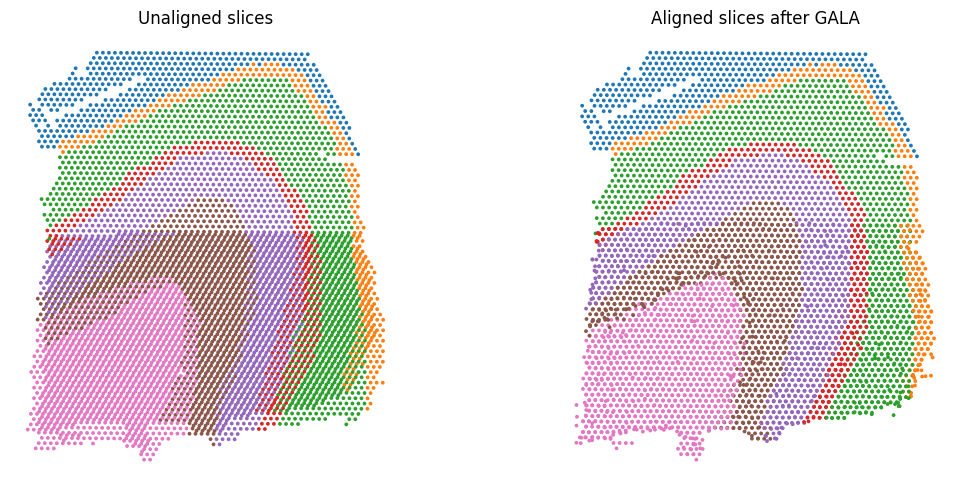

In [14]:
### Load data
# with open(os.path.join(results_path, "resu_bottom_partial_slice3_to_2_SampleC.pkl"), 'rb') as f:
#    resu = pickle.load(f)
xv = resu['xv']
v = resu['v']
A = resu['A']

fs = 30
# Aligned slice by GALA
aligned_source = alignedada(resu, source)
aligned_source.obsm = {'spatial': aligned_source.obsm['aligned'].copy()}

fig, ax = plt.subplots(1,2, figsize=(12,5))
colors_t = list(target.obs['Ground Truth'].astype('str').map(layer_to_color_map))
colors_s = list(aligned_source.obs['Ground Truth'].astype('str').map(layer_to_color_map))
### Unaligned slices    
ax[0].scatter(target.obsm['spatial'][:, 0], target.obsm['spatial'][:, 1],linewidth=0, s=fs, marker=".", color=colors_t)
ax[0].scatter(source.obsm['spatial'][:, 0], source.obsm['spatial'][:, 1],linewidth=0, s=fs, marker=".", color=colors_s)
ax[0].set_title('Unaligned slices', size=12)
ax[0].axis('off')
ax[0].invert_yaxis()
ax[0].set_aspect('equal')

### gala
ax[1].scatter(target.obsm['spatial'][:, 0], target.obsm['spatial'][:, 1],linewidth=0, s=fs, marker=".", color=colors_t)
ax[1].scatter(aligned_source.obsm['spatial'][:, 0], aligned_source.obsm['spatial'][:, 1],linewidth=0, s=fs, marker=".", color=colors_s)
ax[1].set_title('Aligned slices after GALA', size=12)
ax[1].axis('off')
ax[1].invert_yaxis()
ax[1].set_aspect('equal')

plt.tight_layout()
plt.show()

